In [56]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload
import equations as eq
reload (eq);

motion_folder = 'Abduction'
motion_list = ['abduction.mat']
weights_list = [200]
initPos = 'InitPosOptQuat'

model_struct = sc.io.loadmat('../Motions/'+motion_folder+'/OS_model.mat')
data_struct = sc.io.loadmat('../data_model.mat')

start = tm.time()
MM,FO,q,u,fr,frstar,kindeq,xdot, Tau, Torque = eq.create_eoms_eul_torqueDriven(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
me.mprint(Torque)

equations created
[(frame_clavicula, 10*Tau1*frame_clavicula.x + 10*Tau2*frame_clavicula.y + 10*Tau3*frame_clavicula.z), (frame_scapula, 10*Tau4*frame_scapula.x + 10*Tau5*frame_scapula.y + 10*Tau6*frame_scapula.z), (frame_humerus, 10*Tau7*frame_humerus.x + 10*Tau8*frame_humerus.y + 10*Tau9*frame_humerus.z), (frame_ulna, 9.69*Tau10*ulna_rot_frame.x - 2.47*Tau10*ulna_rot_frame.y)]


In [57]:
import trajectory_lib as tr
reload (tr);
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar)

num_nodes = 101
motion_folder = 'Flexion_GL2'
motion_file = 'flexion_GL2.mat'
file = '../Motions/' + motion_folder + '/' + motion_file
traj_original, interval_value, time = tr.exp_trajectory_eul(file,num_nodes)
traj = tr.exp_trajectory_eul_myobj(traj_original)

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(Tau)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

traj_w = 100
vel_w = 0.1
act_w = 0.1

def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj_original.flatten() - free[:10*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = traj_w * 2.0 * interval_value * (free[:10*num_nodes] - traj_original.flatten())
    grad[10*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad
instance_constraints = []
# for i in range(9):
#     instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])

instance_constraints.append(state_symbols[-1].func(0.0)-0)

bounds1 = (-1000,1000)
bounds = (bounds1,)*len(Tau)
bndrs = dict(zip(Tau,bounds))


539.9716732501984
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   120001
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     3030
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1010
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2001
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.27e+00 0.00e+00   0.0 0.00e+00    -  

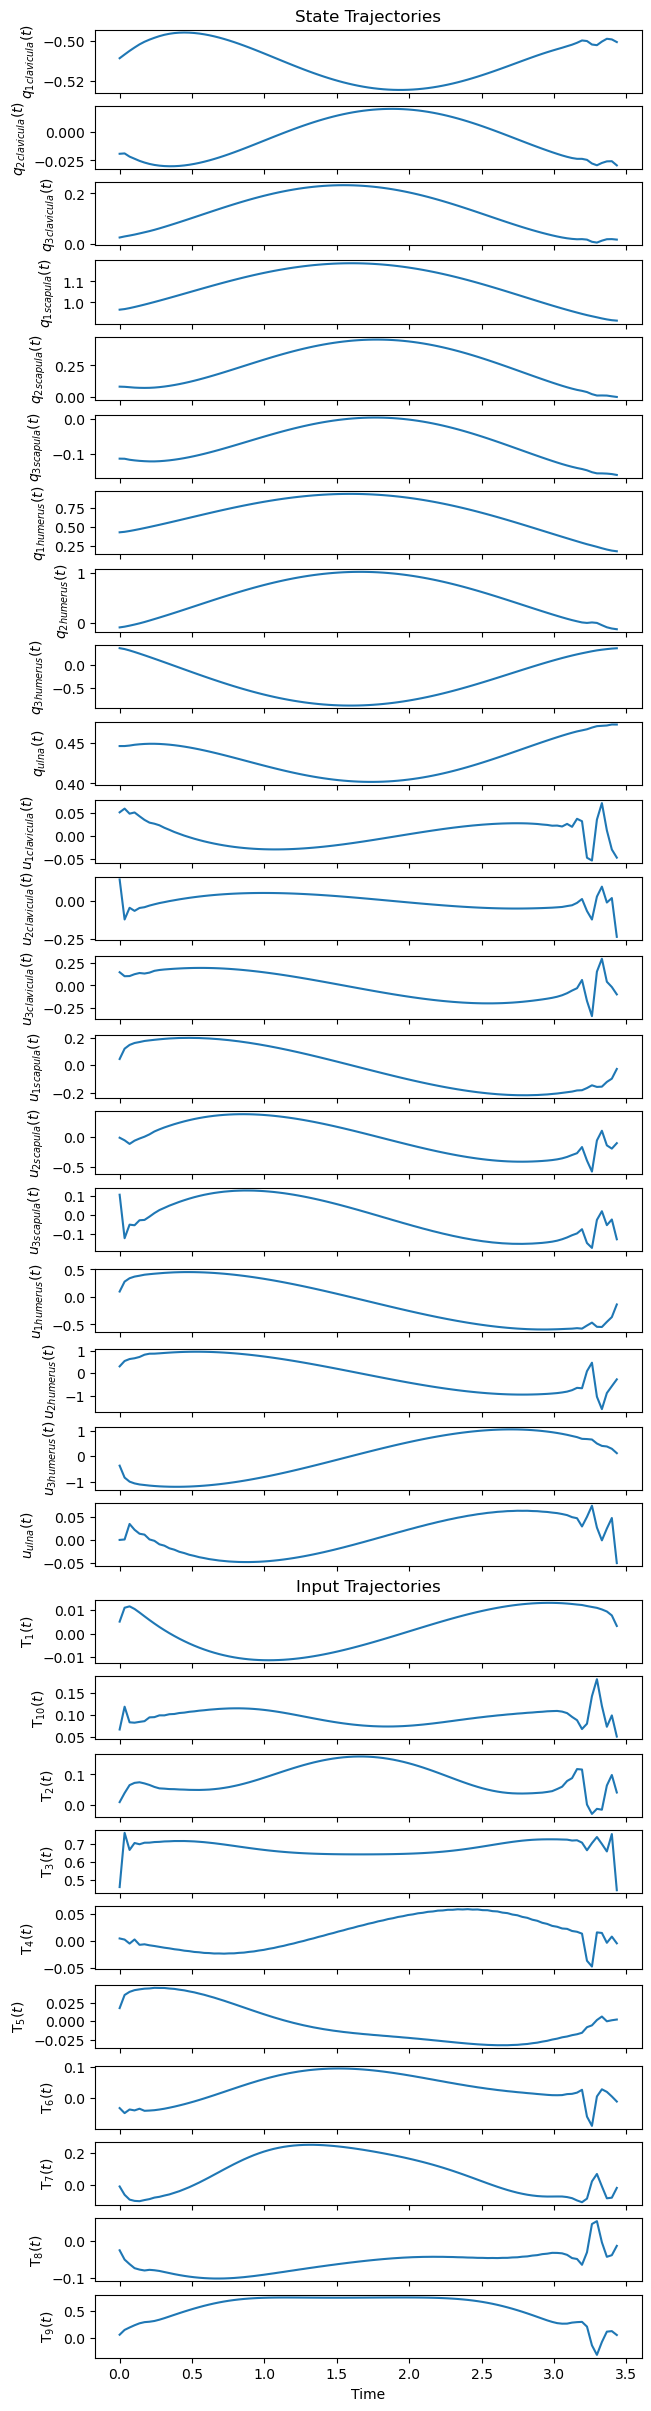

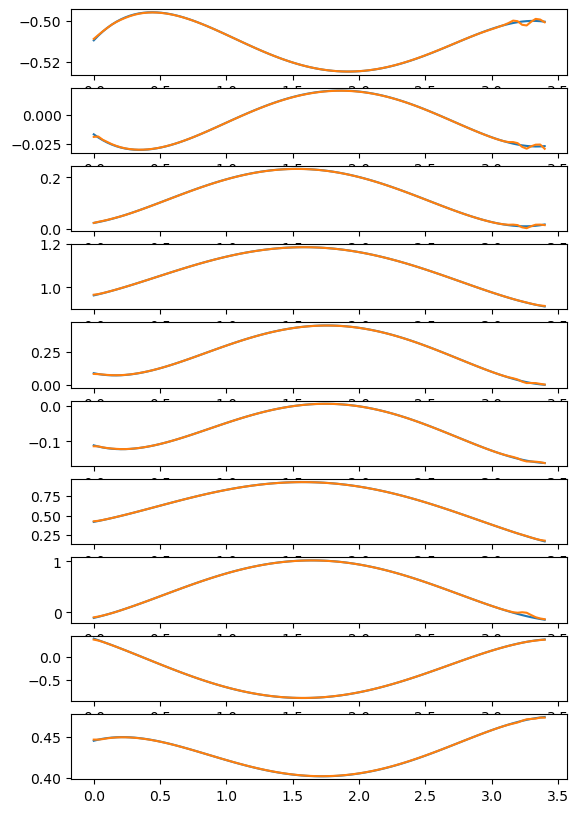

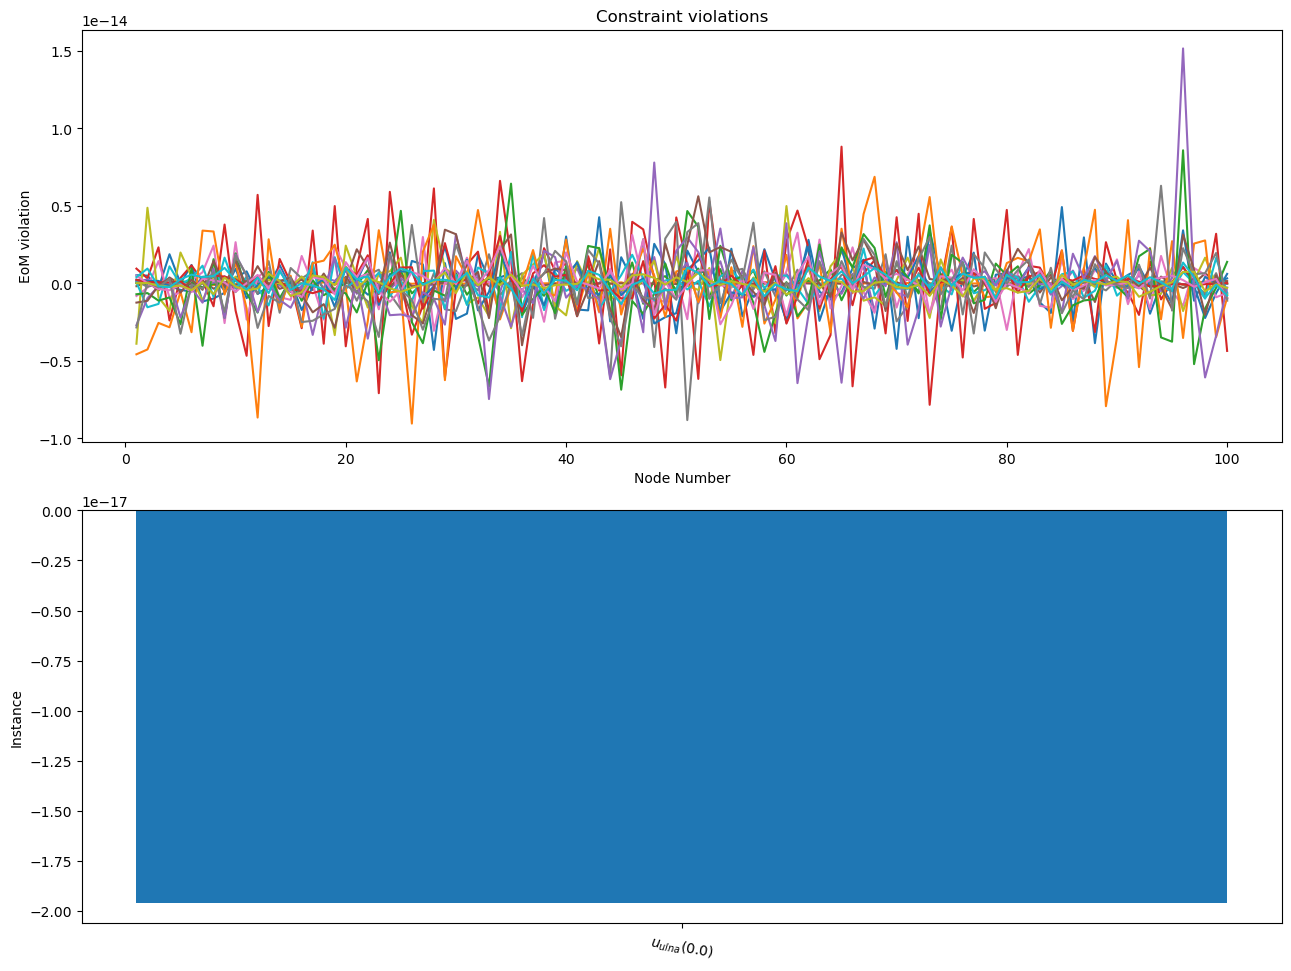

In [58]:
start = tm.time()

prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
            num_nodes, interval_value,
            known_parameter_map={},
            instance_constraints=instance_constraints,
            bounds=bndrs,
            integration_method='midpoint'
) #               
time_to_create = tm.time() - start
print(time_to_create)
prob.add_option('max_iter',2500)
prob.add_option('limited_memory_max_history', 40)
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj_original.flatten()
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                        figsize=(6.4, 0.8*(num_states+num_inputs)),
                        layout='compressed')
prob.plot_trajectories(solution, axes=axes)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj_original.flatten()[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                        layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)